In [1]:
#map TFs binding a promoter to their relevant coefficient of variation - see if they correspond to constitutive or variable
#Count TFs only once (only use unique TFs)
#this script will work for any promoter length

In [1]:
import pandas as pd
#import argparse
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pybedtools import BedTool
import io
#stats
from pingouin import kruskal
import scikit_posthocs as sp
from scipy import stats

In [2]:
# parser = argparse.ArgumentParser(description='map_TF2CV')
# parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
# parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
# parser.add_argument('Czechowski_all_cvs', type=str, help='Input location of Czechowski coefficient of variations for all genes in the microarray')
# parser.add_argument('mapped_motif_bed', type=str, help='Input location of promoters mapped motif bed')
# parser.add_argument('output_folder_name', type=str, help='Optional output folder name ending in a forward slash',default = '')

In [3]:
dependent_variable = 'TFBS_TF_class'
file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
Czechowski_rankedcv = f'../../data/genes/AtGE_dev_gcRMA__all_probes__CV.tsv'
mapped_motif_bed = f'../../data/output/{file_names}/FIMO/promoters_5UTR_motifs_mapped.bed'
output_folder_name = 'promoters_5UTR/'
openchromatin_bed = '../../data/ATAC-seq/potter2018/intersectRootsShoots_PeaksInBoth.bed'
mapped_motif_bed_openchrom = f'../../data/output/{file_names}/FIMO/promoters_5UTR_motifs_mapped_openchromrootshootintersect.bed'

In [4]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class  already exists


In [5]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class/promoters_5UTR/  already exists


In [6]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class/promoters_5UTR/plots  already exists


In [7]:
def intersectbed(mapped_motifs_file,openchrom_bed, output):
    """function to intersect motifs_mapped with open chromatin, dropping any TFs which do not fall within open chromatin"""
    #read in mapped motifs bed
    mapped_motifs = pd.read_table(mapped_motifs_file, sep='\t', header=None)
    #if whole promoter, mapped motif will have 13 columns
    #if shortened promoter, mapped motif file will have 24 (as bp overlap is needed in TF_diversity_plots_shortenedprom.py to remove TFBSs where the middle isn't in the promoter)
    #if 24 columns, only select the subset of 13 columns
    #if 13 columns, keep them all
    #This is to make the dfs have identical column names
    if len(mapped_motifs.columns) == 24:
        cols = ['chr', 'start', 'stop', 'promoter_AGI','dot1','strand','source','type','dot2','attributes',
            'motif_chr','motif_start','motif_stop','name_rep', 'score', 'motif_strand',
            'promoter_AGI2', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI','bp_overlap']
        mapped_motifs.columns = cols
        #filter columns
        mapped_motifs = mapped_motifs[['motif_chr','motif_start','motif_stop','name_rep', 'score', 'motif_strand',
             'promoter_AGI2', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']]
        #rename columns
        cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
        mapped_motifs.columns = cols
        
    else:
        cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
        mapped_motifs.columns = cols
    #remove invalid lines
    mapped_motifs = mapped_motifs[mapped_motifs.chr != '.']
    #save mapped motifs as temporary file
    #save mapped motifs as a buffer
    tempbuffer = io.StringIO()
    #write df to buffer
    mapped_motifs.to_csv(tempbuffer, header=None, index=False,sep='\t')
    #go back to start of buffer
    tempbuffer.seek(0)
    #read in files as bedtool objects
    mapped_motifs2 = BedTool(tempbuffer)
    openchrom = BedTool(openchrom_bed)
    #run bedtools intersect
    #wo,  Write the original A and B entries plus the number of base pairs of overlap between the two features. Only A features with overlap are reported. 
    #f=1 means only include motif is 100% of it is in open chromatin
    intersect = mapped_motifs2.intersect(openchrom, wo=True, f=1).saveas(output) 
    #could add u=True which indicates we want to see the promoters that overlap features in the genome
    #remove buffer
    tempbuffer.close()

In [8]:
def map_cv(ranked_cvs_file,mapped_motifs_file):
    """function to map the CV value to the TFs which bind to each promoter"""
    #read in files
    cvs = pd.read_table(ranked_cvs_file, sep='\t', header=None)
    cols = ['rank','probe_id','TF_AGI','expression_mean','expression_SD','expression_CV','proportion_of_values_present_in_mas5','presence_in_araport11','constitutive_in_araport11']
    cvs.columns = cols
    #filter out any genes that aren't present in araport11
    cvs = cvs[cvs.presence_in_araport11==1]
    #read in mapped motifs
    mapped_motifs = pd.read_table(mapped_motifs_file, sep='\t', header=None)
    #if whole promoter, mapped motif will have 17 columns
    #if shortened promoter, mapped motif file openchrom will have 28 (as bp overlap is needed in TF_diversity_plots_shortenedprom.py to remove TFBSs where the middle isn't in the promoter)
    #if 28 columns, only select the subset of 13 columns
    #if 17 columns, keep them all
    #This is to make the dfs have identical column names

    cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI','chr_chrom','start_chrom','stop_chrom','bp_overlap']
    mapped_motifs.columns = cols
    #filter unwanted columns
    mapped_motifs = mapped_motifs[['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']]
    #merge CV df with mapped_motifs, adding the CVs to the respective TF AGIs
    merged = pd.merge(mapped_motifs, cvs, how='left', on='TF_AGI')
    #Groupby promoter and then keep only unique TFs in each promoter
    #unique_CV_means = merged.groupby(['promoter_AGI', 'TF_AGI'])['expression_mean'].agg(lambda x: x.unique())
    unique_TFs = merged.drop_duplicates(['promoter_AGI', 'TF_AGI']).reset_index(drop=True)

   
    return merged,unique_TFs

In [9]:
def merge_genetype(df, gene_categories):
    """merge df with gene_categories file adding the genetype of the promoters (if in top 100 constitutive or top 100 variable promoters)"""
    gene_cats = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['promoter_AGI','gene_type']
    gene_cats.columns = cols
    merged = pd.merge(gene_cats,df, on='promoter_AGI', how='left')
    return merged

In [10]:
def calculate_mean_SD_CV(df):
    """calculate the mean coefficient of variation of the unique TFs binding to a promoter"""
    #group by promoter and calculate mean for each promoter
    means = df.groupby('promoter_AGI')['expression_CV'].mean()
    #turn into a dataframe
    means_df = pd.DataFrame(means)
    #turn the index into a new column
    means_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['promoter_AGI', 'mean_cv']
    means_df.columns = cols
    
        
    #group by promoter and calculate SD (standard deviation) for each promoter
    sd = df.groupby('promoter_AGI')['expression_CV'].std()
    #turn into a dataframe
    sd_df = pd.DataFrame(sd)
    #turn the index into a new column
    sd_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['promoter_AGI', 'sd']
    sd_df.columns = cols
    
    #merge the dfs
    merged = pd.merge(means_df,sd_df)   
    return merged

In [11]:
def all_prom_distribution(df, x_variable, x_label, output_prefix):
    """function to return distribution plot of all promoters GC content"""    
    
    dist_plot = df[x_variable]
    #create figure with no transparency
    dist_plot_fig = sns.distplot(dist_plot).get_figure()
    plt.xlabel(x_label)

    #save to file
    dist_plot_fig.savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_distribution.pdf', format='pdf')

In [12]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot with specific column order
    plot = sns.catplot(x=x_variable, y=y_variable, data=df, kind=plot_kind, order=["constitutive", "variable", "control"])
    #plot points
    ax = sns.swarmplot(x=x_variable, y=y_variable, data=df, color=".25",order=["constitutive", "variable", "control"])
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')   

In [13]:
# def parallelize_dataframe(df, func, n_cores=4):
#     """parallelize the plot making"""
#     df_split = np.array_split(df, n_cores)
#     pool = Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

In [14]:
#run bedtools intersect to only select motifs in open chomatin
intersectbed(mapped_motif_bed,openchromatin_bed, mapped_motif_bed_openchrom)

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [15]:
#map coefficient of variation (CV) values to each TF in the mapped_motifs file
Czechowski_merged,Czechowski_merged_unique = map_cv(Czechowski_rankedcv, mapped_motif_bed_openchrom)

In [16]:
Czechowski_merged.columns

Index(['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI',
       'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family',
       'TF_AGI', 'rank', 'probe_id', 'expression_mean', 'expression_SD',
       'expression_CV', 'proportion_of_values_present_in_mas5',
       'presence_in_araport11', 'constitutive_in_araport11'],
      dtype='object')

In [17]:
Czechowski_merged

,chr,start,stop,name_rep,score,strand,promoter_AGI,p-value,q-value,matched_sequence,...,TF_family,TF_AGI,rank,probe_id,expression_mean,expression_SD,expression_CV,proportion_of_values_present_in_mas5,presence_in_araport11,constitutive_in_araport11
0,1,3131,3150,ABI3VP1_tnt.VRN1_colamp_a,13.09590,+,AT1G01010,0.000012,0.0131,CTCCTTTGTTTTGCTTTGG,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
1,1,3560,3581,REM_tnt.REM19_colamp_a,9.19118,+,AT1G01010,0.000093,0.0389,ATTAAGAAAATAAAAATAAAA,...,REM,AT1G49480,3890.0,262400_at,671.552167,273.709079,0.407577,98.0,1.0,0.0
2,1,3560,3589,ABI3VP1_tnt.VRN1_col_a,-9.07353,-,AT1G01010,0.000094,0.0301,TTTATTCCTTTTATTTTTATTTTCTTAAT,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
3,1,3561,3590,ABI3VP1_tnt.VRN1_col_a,-8.26471,-,AT1G01010,0.000079,0.0276,ATTTATTCCTTTTATTTTTATTTTCTTAA,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
4,1,3561,3588,C2C2dof_tnt.AT1G69570_col_a,13.36510,-,AT1G01010,0.000013,0.0429,TTATTCCTTTTATTTTTATTTTCTTAA,...,C2C2DOF,AT1G69570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566379,5,26971048,26971077,ABI3VP1_tnt.VRN1_col_a,-8.66176,-,AT5G67640,0.000086,0.0288,TTCTCTTTTATGTTAGTTTTTTTTTTTAT,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
566380,5,26971048,26971063,REM_tnt.REM19_col_a,11.22060,+,AT5G67640,0.000064,0.0347,ATAAAAAAAAAAACT,...,REM,AT1G49480,3890.0,262400_at,671.552167,273.709079,0.407577,98.0,1.0,0.0
566381,5,26971050,26971079,ABI3VP1_tnt.VRN1_col_a,-8.47059,-,AT5G67640,0.000083,0.0282,GCTTCTCTTTTATGTTAGTTTTTTTTTTT,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
566382,5,26971051,26971080,ABI3VP1_tnt.VRN1_col_a,-7.01471,-,AT5G67640,0.000061,0.0240,TGCTTCTCTTTTATGTTAGTTTTTTTTTT,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0


In [18]:
Czechowski_merged_unique

,chr,start,stop,name_rep,score,strand,promoter_AGI,p-value,q-value,matched_sequence,...,TF_family,TF_AGI,rank,probe_id,expression_mean,expression_SD,expression_CV,proportion_of_values_present_in_mas5,presence_in_araport11,constitutive_in_araport11
0,1,3131,3150,ABI3VP1_tnt.VRN1_colamp_a,13.095900,+,AT1G01010,0.000012,0.0131,CTCCTTTGTTTTGCTTTGG,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
1,1,3560,3581,REM_tnt.REM19_colamp_a,9.191180,+,AT1G01010,0.000093,0.0389,ATTAAGAAAATAAAAATAAAA,...,REM,AT1G49480,3890.0,262400_at,671.552167,273.709079,0.407577,98.0,1.0,0.0
2,1,3561,3588,C2C2dof_tnt.AT1G69570_col_a,13.365100,-,AT1G01010,0.000013,0.0429,TTATTCCTTTTATTTTTATTTTCTTAA,...,C2C2DOF,AT1G69570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3609,3628,C2H2_tnt.TF3A_col_a,9.075190,+,AT1G01010,0.000049,0.0488,CTTCACTGTCTTCCTCCCT,...,C2H2,AT1G72050,3917.0,256344_at,432.292941,176.708645,0.408771,98.0,1.0,0.0
4,1,3610,3631,ND_tnt.FRS9_col_a,6.174600,+,AT1G01010,0.000021,0.0181,TTCACTGTCTTCCTCCCTCCA,...,ND,AT4G38170,4890.0,253029_at,69.694512,32.136091,0.461099,83.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123704,5,26970719,26970743,BBRBPC_tnt.BPC1_col_a,-1.312500,-,AT5G67640,0.000070,0.0321,AAGAAAGAAGGAAAAAAAAAGTTT,...,BBRBPC,AT2G01930,5762.0,263305_at,181.275661,92.322959,0.509296,100.0,1.0,0.0
123705,5,26970720,26970741,BBRBPC_tnt.BPC6_col_a,0.219178,+,AT5G67640,0.000034,0.0284,AACTTTTTTTTTCCTTCTTTC,...,BBRBPC,AT5G42520,1524.0,249199_at,493.182683,149.269860,0.302666,98.0,1.0,0.0
123706,5,26970722,26970743,ND_tnt.FRS9_col_a,4.904760,+,AT5G67640,0.000033,0.0243,CTTTTTTTTTCCTTCTTTCTT,...,ND,AT4G38170,4890.0,253029_at,69.694512,32.136091,0.461099,83.0,1.0,0.0
123707,5,26971035,26971064,C2C2dof_tnt.AT5G66940_col_a,14.285700,-,AT5G67640,0.000006,0.0308,TAGTTTTTTTTTTTATCTTTCTCTTATTT,...,C2C2DOF,AT5G66940,11688.0,247066_at,91.950317,159.972423,1.739770,80.0,1.0,0.0


In [19]:
#add gene_types for the promoters (constitutive, variable or control)
Czechowski_genetypes = merge_genetype(Czechowski_merged_unique, Czechowski_gene_categories)

In [20]:
#calculate CV means per promoter
Czechowski_means_sd = calculate_mean_SD_CV(Czechowski_genetypes)

In [21]:
Czechowski_means_sd_genetype = merge_genetype(Czechowski_means_sd, Czechowski_gene_categories)

In [22]:
#remove promoters with no mean_cv
Czechowski_means_sd_genetype = Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.mean_cv.notnull()]

In [23]:
#check how many of each promoter type have mean_cv values
#constitutive
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'constitutive'])

87

In [24]:
#variable
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'variable'])

53

In [25]:
#control
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'control'])

88

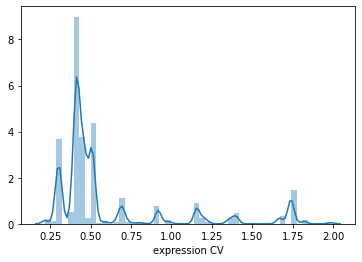

In [26]:
#plot all promoter distribution of TF CV values
all_prom_distribution(Czechowski_genetypes, 'expression_CV', 'expression CV', 'Czechowski_openchrom_expressionCV')

## the CV values seem to mainly have low CVs so tend towards constitutive as in Czechowski et al 2005

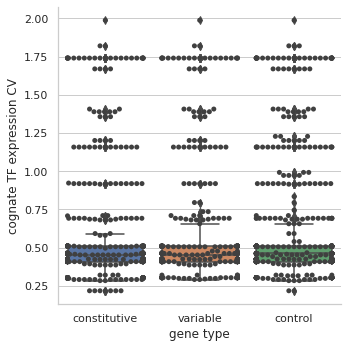

In [27]:
#plot the CV for each promoter gene_type - whole promoter open chromatin individual TF CVs
make_plot(Czechowski_genetypes,'gene_type', 'expression_CV','gene type', 'cognate TF expression CV', 'Czechowski_openchrom_CV', 'box')

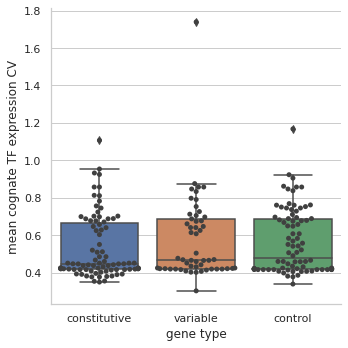

In [28]:
#plot the mean CV for each promoter gene_type - whole promoter open chromatin mean TF CVs
make_plot(Czechowski_means_sd_genetype,'gene_type', 'mean_cv','gene type', 'mean cognate TF expression CV', 'Czechowski_openchrom_CV_mean', 'box')

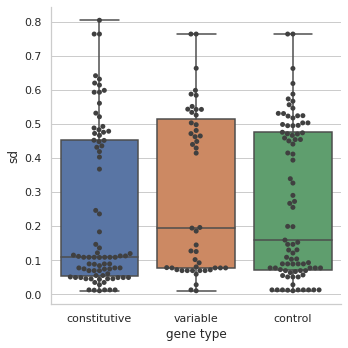

In [34]:
#plot the standard deviation of the CVs of the TFs binding each promoter split into gene_type
make_plot(Czechowski_means_sd_genetype,'gene_type', 'sd','gene type', 'sd', 'Czechowski_openchrom_CV_sd', 'box')

## variable genes seem to have more variation in CV values of TFs that bind them. This makes sense since variable genes seem to have more diverse TFs binding them

In [35]:
# #now plot CV distribution for constitutive genes vs variable genes
#this took too long so commenting out for now
# make_plot(Czechowski_genetypes,'gene_type', 'expression_CV','gene type', 'expression CV', 'Czechowski_CV', 'box')

In [36]:
def test_normality(df,dependent_variable, between):
    """test normality of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #Test normality
    #returns test statistic, p-value
    for name in names:
        print('{}: {}'.format(name, stats.shapiro(df[dependent_variable][df[between] == name])))

In [37]:
def describe_stats(df,dependent_variable, between):
    """return descriptve statistics"""
    return df.groupby([between])[dependent_variable].describe()

In [38]:
def variance(df, dependent_variable, between):
    """test variance of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #test variance    
    return stats.levene(df[dependent_variable][df[between] == names[0]], 
               df[dependent_variable][df[between] == names[1]], 
               df[dependent_variable][df[between] == names[2]])

In [39]:
def kruskal_test(df,dependent_variable,between):
    """Do Kruskal-Wallis analysis"""
    #Kruskal-Wallis one way analysis of variance
    return kruskal(data=df, dv=dependent_variable, between=between)
    

In [40]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

In [41]:
Czechowski_genetypes

,promoter_AGI,gene_type,chr,start,stop,name_rep,score,strand,p-value,q-value,...,TF_family,TF_AGI,rank,probe_id,expression_mean,expression_SD,expression_CV,proportion_of_values_present_in_mas5,presence_in_araport11,constitutive_in_araport11
0,AT4G34270,constitutive,4.0,16406492.0,16406522.0,BBRBPC_tnt.BPC5_col_a,-48.57690,-,7.390000e-05,0.0386,...,BBRBPC,AT4G38910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT4G34270,constitutive,4.0,16406500.0,16406521.0,ND_tnt.FRS9_col_a,5.68254,+,2.530000e-05,0.0203,...,ND,AT4G38170,4890.0,253029_at,69.694512,32.136091,0.461099,83.0,1.0,0.0
2,AT4G34270,constitutive,4.0,16406500.0,16406521.0,BBRBPC_tnt.BPC6_col_a,-2.58904,+,7.530000e-05,0.0478,...,BBRBPC,AT5G42520,1524.0,249199_at,493.182683,149.269860,0.302666,98.0,1.0,0.0
3,AT4G33380,constitutive,4.0,16071850.0,16071871.0,BBRBPC_tnt.BPC6_col_a,1.84932,+,2.060000e-05,0.0203,...,BBRBPC,AT5G42520,1524.0,249199_at,493.182683,149.269860,0.302666,98.0,1.0,0.0
4,AT4G33380,constitutive,4.0,16071850.0,16071865.0,BBRBPC_tnt.BPC1_colamp_a,7.65625,+,3.950000e-05,0.0331,...,BBRBPC,AT2G01930,5762.0,263305_at,181.275661,92.322959,0.509296,100.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2439,AT4G27652,control,4.0,13809831.0,13809853.0,MYBrelated_tnt.AT1G18960_col_a,17.20550,+,4.090000e-07,0.0425,...,MYBRELATED,AT1G18960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2440,AT4G27652,control,4.0,13809887.0,13809906.0,C2H2_tnt.TF3A_col_a,11.11280,+,1.740000e-05,0.0320,...,C2H2,AT1G72050,3917.0,256344_at,432.292941,176.708645,0.408771,98.0,1.0,0.0
2441,AT4G27652,control,4.0,13809887.0,13809902.0,C2C2dof_tnt.AT1G47655_colamp_a,13.09380,+,1.120000e-05,0.0471,...,C2C2DOF,AT1G47655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2442,AT5G65710,control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#rename df for easier analysis
df = Czechowski_means_sd_genetype
between_variable = 'gene_type'
dependent_variable = 'mean_cv'

In [43]:
test_normality(df,dependent_variable,between_variable)

constitutive: ShapiroResult(statistic=0.8167392611503601, pvalue=5.140911696344119e-09)
variable: ShapiroResult(statistic=0.7261297702789307, pvalue=1.2923363712502578e-08)
control: ShapiroResult(statistic=0.8628823161125183, pvalue=1.5981164835920936e-07)


## not normal

In [44]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=0.8069423868570957, pvalue=0.447507435846599)

### fail to reject null hypothesis that variances are equal

In [45]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,87.0,0.530183,0.168506,0.349675,0.417395,0.446686,0.664098,1.107077
control,88.0,0.559288,0.169803,0.338951,0.419046,0.478264,0.688662,1.167887
variable,53.0,0.577101,0.226571,0.302666,0.421101,0.469025,0.687314,1.739770


In [46]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,2.574633,0.276011


In [47]:
# no significant difference in CV values between constitutive and variable or control 400bp promoters

In [48]:
dunn_posthoc_test(df, dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.000000,0.74564,0.395657
control,0.745640,-1.00000,1.000000
variable,0.395657,1.00000,-1.000000


In [49]:
## test to see if difference in standard_deviation between CV values of TFs binding each promoter for each promoter gene type

In [50]:
#rename df for easier analysis
df = Czechowski_means_sd_genetype
between_variable = 'gene_type'
dependent_variable = 'sd'

In [51]:
test_normality(df,dependent_variable,between_variable)

constitutive: ShapiroResult(statistic=nan, pvalue=1.0)
variable: ShapiroResult(statistic=nan, pvalue=1.0)
control: ShapiroResult(statistic=nan, pvalue=1.0)


In [52]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,83.0,0.233007,0.230431,0.009657,0.054427,0.108105,0.451826,0.804745
control,85.0,0.268158,0.222032,0.009657,0.071926,0.158712,0.475567,0.764199
variable,47.0,0.298684,0.237788,0.009657,0.076801,0.193835,0.514530,0.764199


In [53]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,3.24409,0.197494


In [54]:
## no significant difference in TFBS CV sd between the promoter types